# Importing modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sbn

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from skfuzzy.cluster import cmeans, cmeans_predict
from sklearn.metrics.pairwise import cosine_similarity

# Fuzzy C means Class

In [2]:
class Pas_comme_ça_zinedine(ValueError, AttributeError):
    pass

class FCmeans():
    #Constructor
    def __init__(self, n_clusters : int, m : int = 2, error : float = 10**-3, max_iter : int = 10**3, init = "k-means++", seed : int = None):
        self.n_clusters = n_clusters    #Number of cluster
        self.m = m                      #Array exponentiation applied to the membership function u_old at each iteration, where U_new = u_old ** m.
        self.error = error              #Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error
        self.max_iter = max_iter        #Maximum number of iterations allowed.
        self.init = init                #Initial fuzzy c-partitioned matrix. If none provided, algorithm is randomly initialized.
        self.seed = seed                #Sets random seed of init
        self.train = False


    def fit(self, X : np.ndarray):
        km = KMeans(self.n_clusters, max_iter=self.max_iter, random_state=self.seed, init=self.init)
        km.fit(X)
        self.centers = km.cluster_centers_
        self.inertia = km.inertia_
        self.n_iter = km.n_iter_
        self.train = True



    def soft_predict(self, X: np.ndarray) -> np.ndarray:
        if self.train:
            return cmeans_predict(X.T, self.centers, self.m, self.error, self.max_iter, init=None, seed=None)[0].T
        else:
            raise Pas_comme_ça_zinedine("Il faut fit avant ! Eh ouai le bouf...")
                

    def predict(self, X : np.ndarray):
        return self.soft_predict(X).argmax(axis=-1)

# 2 - Get all files needed

In [3]:
data_folder = "../../Dataset/Movie/"

In [4]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId").drop(["genres", "movieId"], axis=1)
data.shape

(25000095, 3)

# 3 - Transforming data

In [5]:
#On garde les NB_FILM films les plus notés
NB_FILM = 500
keep_title = data["title"].value_counts().sort_values(ascending=False)[:NB_FILM].index
data_title = data[data["title"].isin(keep_title)]
data_title.shape

(10944751, 3)

In [6]:
#On garde les users qui ont données une note sur au moins THRESH_USER % des films
THRESH_USER = 0.40
keep_user = data_title["userId"].value_counts()/NB_FILM >= THRESH_USER
data_title_user = data_title[data_title["userId"].isin(keep_user[keep_user].index)]

In [7]:
#On fait notre pivot table
user_title_df = data_title_user.pivot_table(index="userId", columns="title", values="rating")
user_title_df.to_csv(f"{data_folder}test_for_users.csv")
user_title_df.shape

(10103, 500)

# Mis en forme des données

In [8]:
def normalization_min_max(row):
    return (row - row.mean())/(row.max() - row.min())

In [9]:
for_users_data = user_title_df.fillna(0).apply(normalization_min_max, axis=1)
for_movies_data = user_title_df.fillna(0).apply(normalization_min_max, axis=0)

In [128]:
#Création de la matrice de cosinus distance
all_users = user_title_df.index
cos = cosine_similarity(for_users_data)
similarity_users = pd.DataFrame(cos, index=all_users, columns=all_users)
np.fill_diagonal(similarity_users.values, 0)


#Création de la matrice de cosinus distance
all_movies = user_title_df.columns
cos = cosine_similarity(for_movies_data.T)
similarity_movies= pd.DataFrame(cos, index=all_movies, columns=all_movies)
np.fill_diagonal(similarity_movies.values, 0)


del(cos)

# Guess Algo

In [138]:
#On devine la note en fonction des candidtats similaires
def guess_rate(user, title, N, similarity_users):
    all_similar_users = similarity_users.loc[user].sort_values(ascending=False).index
    user_title_mat = for_users_data
    
    rate = 0
    weight = 0
    k = 0
    i = 0

    while (k < N):
        similar_user = all_similar_users[i]
        r = user_title_mat.loc[similar_user, title]

        if not (pd.isnull(r)):
            w = similarity_users.loc[similar_user, user]
            rate += w*r
            weight += w
            k += 1

        i += 1

    return rate/weight

In [139]:
def get_similar_movies_from_users(user_id, N, similarity_users):
    all_rates = []
    keep_movies = []

    for movie in tqdm(user_title_df.columns):
        if (pd.isnull(user_title_df.loc[user_id, movie])):
            all_rates.append(guess_rate(user_id, movie, N, similarity_users))
            keep_movies.append(movie)

    return pd.Series(all_rates, keep_movies).sort_values(ascending=False)

In [140]:
def get_similar_movies_from_movies(user_id, similarity_movies):
    similar_movies = []

    movies_rates = user_title_df.loc[user_id].dropna()
    movies = movies_rates.index
    rates = movies_rates.values
    user = [(movies[i], rates[i]) for i in range(len(rates))]

    for movie, rate in tqdm(user):
        movie_list = (similarity_movies.loc[:, movie]*(rate-2.5)).sort_values(ascending=False)
        similar_movies.append(movie_list)

    similar_movies = pd.concat(similar_movies, axis=1)
    similar_movies = similar_movies.drop([movie for movie, rate in user], axis=0)
    return similar_movies.sum(axis=1).sort_values(ascending=False)

In [141]:
def recommanded_movies(user_id, similarity_users, similarity_movies):
    get_users = get_similar_movies_from_users(user_id, 15, similarity_users)
    get_movies = get_similar_movies_from_movies(user_id, similarity_movies)

    arg_movies = []
    for title in get_users.index:
        arg_movies.append(int(np.argwhere(get_movies.index == title)))

    recommanded = pd.DataFrame(index=get_users.index, columns=["Arg Users", "Arg Movies"], data=np.array([range(len(arg_movies)), arg_movies]).T)
    recommanded["Mean"] = recommanded.mean(axis=1)

    return recommanded.sort_values(by="Mean")

# Find K

In [85]:
N = 10
K_RANGE = range(2, N+1)
all_inertia = {"Users" : [], "Movies" : []}
data = {"Users" : for_users_data.values, "Movies" : for_movies_data.T.values}

for key in all_inertia.keys():
    for k in tqdm(K_RANGE):
        fcm = FCmeans(k)
        fcm.fit(data[key])
        all_inertia[key].append(fcm.inertia)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

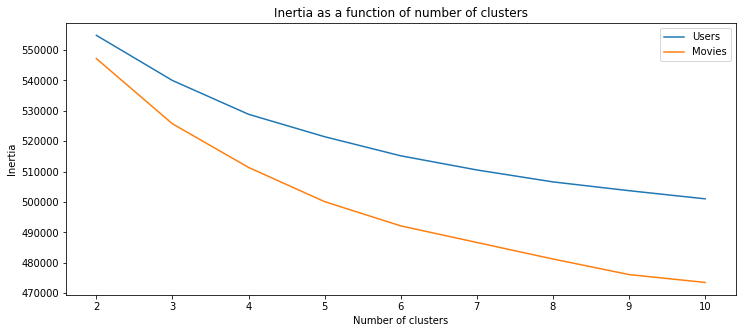

In [86]:
plt.figure(figsize=(12,5))

i = 0
for key in all_inertia.keys():
    plt.plot(K_RANGE, all_inertia[key], label=key)

plt.xticks(K_RANGE)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.title("Inertia as a function of number of clusters")
plt.legend()

plt.show()

# 1er méthode : similarité entre les appartenance aux clusters

In [12]:
fcm = FCmeans(3)
fcm.fit(for_users_data.values)
soft_pred = fcm.soft_predict(for_users_data.values)

In [13]:
users = for_users_data.index
membership_users = pd.DataFrame(index=users, columns=[f"% Cluster {i+1}" for i in range(soft_pred.shape[1])])
membership_users.iloc[:, :] = soft_pred
membership_users["Final Cluster"] = membership_users.loc[:,:].values.argmax(axis=-1) + 1

membership_users

,% Cluster 1,% Cluster 2,% Cluster 3,Final Cluster
userId,,,,
12,0.342618,0.291434,0.365947,3
31,0.376884,0.30941,0.313706,1
43,0.39494,0.286816,0.318245,1
72,0.308963,0.221426,0.469611,3
120,0.331027,0.245507,0.423467,3
...,...,...,...,...
162512,0.370603,0.343831,0.285566,1
162516,0.312428,0.438186,0.249386,2
162519,0.31992,0.264577,0.415503,3


In [20]:
fcm = FCmeans(3)
fcm.fit(for_movies_data.T.values)
soft_pred = fcm.soft_predict(for_movies_data.T.values)

In [21]:
movies = for_movies_data.columns
membership_movies = pd.DataFrame(index=movies, columns=[f"% Cluster {i+1}" for i in range(soft_pred.shape[1])])
membership_movies.iloc[:, :] = soft_pred
membership_movies["Final Cluster"] = membership_movies.loc[:,:].values.argmax(axis=-1) + 1

membership_movies

,% Cluster 1,% Cluster 2,% Cluster 3,Final Cluster
title,,,,
(500) Days of Summer (2009),0.258565,0.468075,0.27336,2
10 Things I Hate About You (1999),0.292762,0.311075,0.396162,3
12 Angry Men (1957),0.379303,0.314561,0.306136,1
2001: A Space Odyssey (1968),0.41977,0.270368,0.309862,1
28 Days Later (2002),0.287724,0.404127,0.30815,2
...,...,...,...,...
X-Men (2000),0.269397,0.328337,0.402266,3
X2: X-Men United (2003),0.2599,0.386079,0.354021,2
You've Got Mail (1998),0.30883,0.269126,0.422044,3


In [127]:
cos = cosine_similarity(membership_users.iloc[:,:-1])
similarity_users_cluster = pd.DataFrame(cos, index=users, columns=users)
cos = cosine_similarity(membership_movies.iloc[:,:-1])
similarity_movies_cluster = pd.DataFrame(cos, index=movies, columns=movies)
del(cos)

In [142]:
test_cluster = recommanded_movies(12, similarity_users_cluster, similarity_movies_cluster)
test = recommanded_movies(12, similarity_users, similarity_movies)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

In [143]:
np.abs(test_cluster["Mean"].values - test["Mean"].values).mean()

4.548387096774194